# KPNO Weather

Companion notebook to DESI-doc-3087, used to analyze MzLS weather data and make plots.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.signal
import scipy.optimize

In [3]:
import astropy.table
import astropy.time

In [4]:
import desimodel.weather

Read time series of MzLS transparency and seeing values compiled by Kyle Dawson from MzLS logs:

In [5]:
def read_weather(name='MzLS_weather.fits'):
    w = astropy.table.Table.read(name)
    mjd = w['MJD']
    n = len(np.unique(np.floor(mjd)))
    start = astropy.time.Time(np.min(mjd), format='mjd').datetime.date()
    stop = astropy.time.Time(np.max(mjd), format='mjd').datetime.date()
    print('Read data from {0} nights spanning {1} to {2}.'.format(n, start, stop))
    return w

weather = read_weather()

Read data from 233 nights spanning 2015-12-14 to 2017-06-16.


## Atmospheric Seeing

Compare with the previous model:

In [6]:
def seeing_from_diq(diq_fwhm, blur=0.219):
    const = 2 * np.sqrt(2 * np.log(2))
    return const * np.sqrt((diq_fwhm / const) ** 2 - blur ** 2)

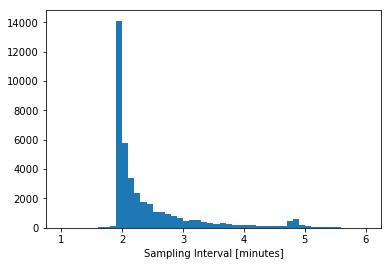

In [7]:
def get_seeing(max_seeing=2.5):
    mjd = weather['MJD'].data.astype(np.float64)
    # Remove factor of 1.1 applied by Kyle.
    diq = weather['SEEING'].data.astype(np.float32)
    # Calculate corresponding seeing.
    seeing = seeing_from_diq(diq)
    # Limit results to max seeing.
    valid = seeing < max_seeing
    # Plot distribution of sampling intervals.
    plt.hist(60 * 24 * np.diff(mjd[valid]), bins=50, range=(1, 6))
    plt.xlabel('Sampling Interval [minutes]')

    return mjd[valid], diq[valid], seeing[valid]

mjd_seeing, diq, seeing = get_seeing()

In [8]:
def seeing_fit_model(p, x):
    y = (1 + ((x - p[0]) / p[1]) ** 2) ** (-p[2]) * x ** p[3]
    return y / (y.sum() * np.gradient(x))

In [9]:
def seeing_residuals(p, x, ydata, dyinv):
    return dyinv * (seeing_fit_model(p, x) - ydata)

B = 0.0751 \quad,\quad C = 0.443 \quad,\quad D = 23.0 \quad,\quad E = 38.1


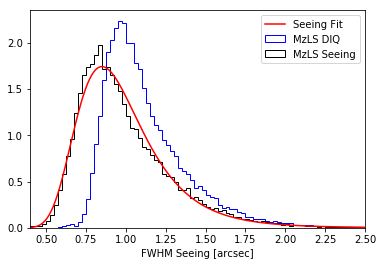

In [10]:
def fit_seeing(nbins=100, seeing_max=2.5, save=None):
    # histogram seeing values
    ydata, edges = np.histogram(seeing, bins=nbins, range=(0., seeing_max))
    dyinv = np.zeros(len(ydata))
    nonzero = ydata > 0
    dyinv[nonzero] = 1. / np.sqrt(ydata[nonzero])
    ynorm = ydata.sum() * np.diff(edges)
    ydata = ydata.astype(float) / ynorm
    dyinv /= ynorm
    assert np.all(np.isfinite(dyinv))
    x = 0.5 * (edges[1:] + edges[:-1])
    # perform least-squares fit to Dey & Valdes model.
    p0 = [0.46, 0.53, 21., 41.]
    pmin = [0., 0., 0., 0.]
    pmax = [2., 2., 100., 100.]
    fit = scipy.optimize.least_squares(
        seeing_residuals, p0, args=(x, ydata, dyinv), bounds=(pmin, pmax))
    pfit = fit.x
    print('B = {:.4f} \quad,\quad C = {:.3f} \quad,\quad D = {:.1f} \quad,\quad E = {:.1f}'
          .format(*pfit))
    xfit = np.linspace(0, seeing_max, 4 * nbins)
    yfit = seeing_fit_model(pfit, xfit)
    plt.hist(diq, bins=edges, normed=True, color='b', histtype='step', label='MzLS DIQ')
    plt.hist(x, bins=edges, weights=ydata, color='k', histtype='step', label='MzLS Seeing')
    plt.plot(xfit, yfit, 'r-', label='Seeing Fit')
    plt.legend(loc='upper right')
    plt.xlabel('FWHM Seeing [arcsec]')
    plt.xlim(0.4, seeing_max)
    if save:
        plt.savefig(save)
    return pfit
    
seeing_fit = fit_seeing() #save='seeing-fit.pdf')

slope = 0.931 , offset = 0.000000
Scale = 1.18150 for median 1.100" (clip = 2.954")


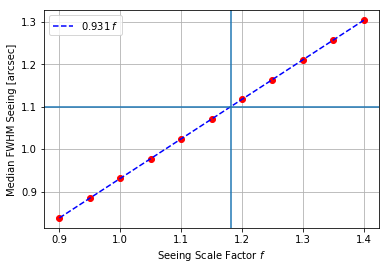

In [11]:
def seeing_median(max_seeing=2.5, nominal=1.1, save=None):
    # Tabulate the nominal (scale=1) seeing PDF.
    fwhm = np.linspace(0., max_seeing, 250)
    pdf = seeing_fit_model(seeing_fit, fwhm)
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    scale = np.linspace(0.9, 1.4, 11)
    median = np.empty_like(scale)
    for i, s in enumerate(scale):
        median[i] = np.interp(0.5, cdf, s * fwhm)
    plt.plot(scale, median, 'ro')
    x1, x2 = scale[0], scale[-1]
    y1, y2 = median[0], median[-1]
    slope = (y2 - y1) / (x2 - x1)
    offset = y1 - slope * x1
    assert np.abs(offset) < 1e-6
    plt.plot([x1, x2], [y1, y2], 'b--', label='${:.3f}\, f$'.format(slope))
    print('slope = {:.3f} , offset = {:.6f}'.format(slope, offset))
    plt.legend(loc='upper left')
    scale0 = (nominal - offset) / slope
    plt.axhline(nominal)
    plt.axvline(scale0)
    print('Scale = {:.5f} for median {:.3f}" (clip = {:.3f}")'
          .format(scale0, nominal, scale0 * max_seeing))
    
    plt.xlabel('Seeing Scale Factor $f$')
    plt.ylabel('Median FWHM Seeing [arcsec]')
    plt.grid()
    if save:
        plt.savefig(save)
    
seeing_median() #save='seeing-scale.pdf')

In [12]:
def print_seeing_stats(label, median, mu, rms, x0=1.1):
    a,b,c = 4.6, -1.55, 1.15
    f0 = a + b * x0 + c * x0 ** 2
    fmu = a + b * mu + c * mu ** 2
    g = (b + 2 * c * mu) ** 2 / fmu ** 2 - c / fmu
    Fx = (fmu / f0) / (1 + g * rms ** 2)
    print('{}: ${:.2f}$ & ${:.2f}$ & ${:.2f}$ & ${:.2f}$ & ${:.2f}$'
          .format(label, median, mu, rms, g, Fx))

In [13]:
def old_seeing_model(x, blur=0.219):
    """Evalute the old model from desimodel.seeing (now deprecated)
    """
    # convert from seeing to DIQ
    const = 2 * np.sqrt(2 * np.log(2))
    diq = const * np.sqrt((x / const) ** 2 + blur ** 2)
    # Evaluate the seeing distribution for the "r SDSS k1018" filter
    # reported in Dey & Valdes.
    p = np.array([ 0.4630833, 0.52700073, 14.632419, 30.287271])
    y = (1 + ((diq - p[0]) / p[1]) ** 2) ** (-p[2]) * diq ** p[3]
    return y / (y.sum() * np.gradient(x))

Old Model: $1.16$ & $1.28$ & $0.49$ & $-0.16$ & $1.09$
New Model: $1.00$ & $1.06$ & $0.31$ & $-0.23$ & $1.01$
New Model: $1.10$ & $1.17$ & $0.34$ & $-0.20$ & $1.04$
New Model: $1.20$ & $1.27$ & $0.37$ & $-0.16$ & $1.07$


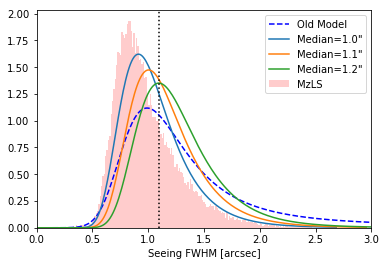

In [14]:
def plot_seeing_pdf(save=None):
    fwhm = np.linspace(0., 3., 250)
    # Tabulate and plot the old PDF model.
    old_model = old_seeing_model(fwhm)
    plt.plot(fwhm, old_model, 'b--', label='Old Model')
    # Calculate statistics of the old model.
    old_mean = (fwhm * old_model).sum() / old_model.sum()
    old_s2 = (fwhm ** 2 * old_model).sum() / old_model.sum()
    old_rms = np.sqrt(old_s2 - old_mean ** 2)
    old_cdf = np.cumsum(old_model)
    old_cdf /= old_cdf[-1]
    old_median = np.interp(0.5, old_cdf, fwhm)
    print_seeing_stats('Old Model', old_median, old_mean, old_rms)
    # Compare with the MzLS data.
    plt.hist(seeing, bins=fwhm, normed=True, color='r', label='MzLS', histtype='stepfilled', alpha=0.2)
    plt.xlim(0, 3)
    plt.xlabel('Seeing FWHM [arcsec]')
    # Compare with scaled MzLS models.
    for median in (1.0, 1.1, 1.2):
        x, y = desimodel.weather.get_seeing_pdf(median)
        plt.plot(x, y, label='Median={:.1f}"'.format(median))
        new_mean = np.sum(x * y) / np.sum(y)
        s2 = np.sum(x ** 2 * y) / np.sum(y)
        rms = np.sqrt(s2 - new_mean ** 2)
        print_seeing_stats('New Model', median, new_mean, rms)
    plt.legend(loc='upper right')
    plt.axvline(1.1, ls=':', c='k')
    if save:
        plt.savefig(save)

plot_seeing_pdf() #save='seeing-pdf.pdf')

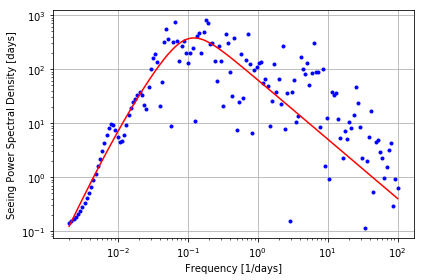

In [15]:
def plot_seeing_psd(max_seeing=2.5, save=None):
    whiten, unwhiten = desimodel.weather.whiten_transforms(seeing, data_min=0, data_max=max_seeing)
    seeing_w = whiten(seeing)
    freq = np.logspace(np.log10(0.002), 2, 150)
    pgram = scipy.signal.lombscargle(mjd_seeing, seeing_w, freq)
    plt.plot(freq, pgram, 'b.')
    plt.plot(freq, desimodel.weather._seeing_psd(freq), 'r-')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.xlabel('Frequency [1/days]')
    plt.ylabel('Seeing Power Spectral Density [days]')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_seeing_psd() #save='seeing-psd.pdf')

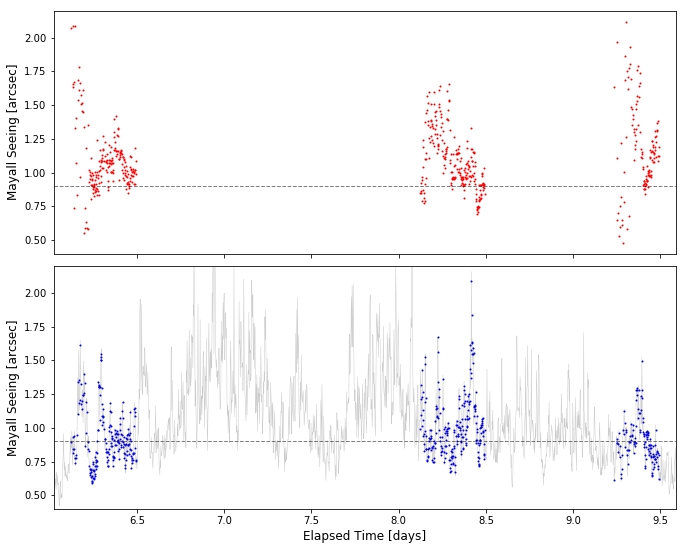

In [16]:
def plot_seeing_timeseries(seed=5, truth=False, pad=0.1, save=None):

    fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 8))
    
    mjd1, mjd2 = 57500, 57510
    sel = (mjd_seeing > mjd1) & (mjd_seeing < mjd2)
    t_data = (mjd_seeing[sel] - mjd1)
    data = seeing[sel]
    ax[0].scatter(t_data, data, c='r', s=1)
    ax[0].set_ylabel('Mayall Seeing [arcsec]', fontsize='large')
    ax[0].axhline(0.9, lw=1, ls='--', c='k', alpha=0.5)
    
    gen = np.random.RandomState(seed)
    dt_sec = 180.
    n_gen = int(np.ceil((t_data[-1] + pad) * 24. * 3600. / dt_sec))
    t_sim = np.arange(n_gen) * dt_sec / (24 * 3600.)
    sim = desimodel.weather.sample_seeing(n_gen, dt_sec=dt_sec, median_seeing=0.923, gen=gen)
    
    # Interpolate simulated grid to actual observation times.
    sim_data = np.interp(t_data, t_sim, sim)
    
    if truth:
        ax[1].plot(t_sim, sim, 'k-', alpha=0.2, lw=0.5)
    ax[1].scatter(t_data, sim_data, c='b', s=1)
    ax[1].set_xlim(t_data[0] - pad, t_data[-1] + pad)
    ax[1].set_xlabel('Elapsed Time [days]', fontsize='large')
    ax[1].set_ylabel('Mayall Seeing [arcsec]', fontsize='large')
    ax[1].set_ylim(0.4, 2.2)
    ax[1].axhline(0.9, lw=1, ls='--', c='k', alpha=0.5)
    
    plt.subplots_adjust(hspace=0.05, right=0.99, top=0.99)
    if save:
        plt.savefig(save)
    
plot_seeing_timeseries(seed=2, truth=True) #,save='seeing-sim.png')

In [17]:
def seeing_expfac(n=100000, x0=1.1, seed=123):
    a,b,c = 4.6, -1.55, 1.15
    f0 = a + b * x0 + c * x0 ** 2
    gen = np.random.RandomState(seed)
    # Generate samples with the new model, using different medians.
    for median in (1.0, 1.1, 1.2):
        x = desimodel.weather.sample_seeing(n, median_seeing=median, gen=gen)
        fx = a + b * x + c * x ** 2
        Fx = 1 / np.mean(f0 / fx)
        print('New Model: median {:.2f} Fx = {:.2f}'.format(np.median(x), Fx))
    # Generate samples with the old model truncated at 3 arcsec.
    x_grid = np.linspace(0, 3, 250)
    pdf_grid = old_seeing_model(x_grid)
    x = desimodel.weather.sample_timeseries(x_grid, pdf_grid, desimodel.weather._seeing_psd, n)
    fx = a + b * x + c * x ** 2
    Fx = 1 / np.mean(f0 / fx)
    print('Old Model: median {:.2f} Fx = {:.2f} mean = {:.2f} rms = {:.2f}'
          .format(np.median(x), Fx, np.mean(x), np.std(x)))
            
seeing_expfac()

New Model: median 1.00 Fx = 1.01
New Model: median 1.10 Fx = 1.03
New Model: median 1.20 Fx = 1.06
Old Model: median 1.16 Fx = 1.08 mean = 1.28 rms = 0.50


# Transparency

In [18]:
def correct(mjd, mjd1, mjd2, y1, y2):
    sel = (mjd >= mjd1) & (mjd < mjd2)
    slope = (y2 - y1) / (mjd2 - mjd1)
    y = y1 + (mjd[sel] - mjd1) * slope
    return sel, 1. / y

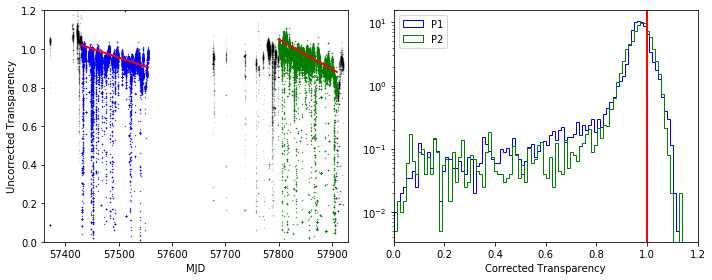

In [19]:
def get_transp(max_transp=1.2, save=None):
    mjd = weather['MJD'].data.astype(np.float64)
    uncorr = weather['TRANSPARENCY'].copy().astype(np.float32)
    
    s1, c1 = correct(mjd, 57430., 57560., 1.02, 0.90)
    s2, c2 = correct(mjd, 57800., 57910., 1.05, 0.88)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    ax[0].scatter(mjd, uncorr, s=0.1, color='k', alpha=0.2)
    ax[0].scatter(mjd[s1], uncorr[s1], s=0.1, color='b')
    ax[0].scatter(mjd[s2], uncorr[s2], s=0.1, color='g')
    ax[0].plot(mjd[s1], 1 / c1, 'r-', lw=2)
    ax[0].plot(mjd[s2], 1 / c2, 'r-', lw=2)
    ax[0].set_ylim(0, max_transp)
    ax[0].set_xlim(mjd[0] - 10, mjd[-1] + 10)
    ax[0].set_ylabel('Uncorrected Transparency')
    ax[0].set_xlabel('MJD')
    
    ax[1].hist(c1 * uncorr[s1], bins=100, range=(0, 1.2), normed=True,
               histtype='step', color='b', label='P1')
    ax[1].hist(c2 * uncorr[s2], bins=100, range=(0, 1.2), normed=True,
               histtype='step', color='g', label='P2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlim(0, max_transp)
    ax[1].axvline(1, color='r', ls='-', lw=2)
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Corrected Transparency')
    
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
    # Apply corrections.
    transp = uncorr.copy()
    transp[s1] *= c1
    transp[s2] *= c2
    s12 = (s1 | s2) & (transp < max_transp)
    return mjd[s12], transp[s12]

mjd_transp, transp = get_transp() #save='transp-trend.png')

Specify the parameters of the corrected transparency PDF:

In [20]:
def sample_transp_pdf(n=10000, rms=0.035, seed=123):
    gen = np.random.RandomState(seed)
    f = gen.uniform(size=n)
    x = gen.uniform(size=n)
    done = np.zeros(n, bool)
    for c, p in zip(desimodel.weather._transp_pdf_cum,
                    desimodel.weather._transp_pdf_powers):
        sel = (f < c) & ~done
        x[sel] = np.power(x[sel], 1. / (1. + p))
        done = done | sel
    dx = rms * gen.normal(size=n)
    return x, dx

Deconvolved: median = 0.978 mean = 0.939, 0.935 rms = 0.142, 0.145
Old model: median = 1.000 mean = 0.929 rms = 0.124


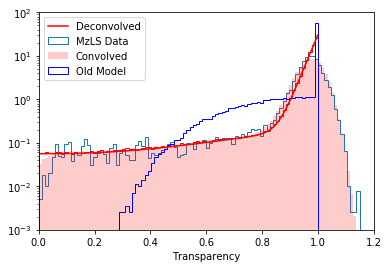

In [21]:
def plot_transp_pdf(save=None):
    # Histogram corrected transparency in MzLS data.
    plt.hist(transp, bins=100, range=(0,1.15), normed=True, histtype='step',
             ls='-', label='MzLS Data')

    # Histogram the corrected transparency model and corresponding
    # deconvolved model for a random sample.
    tgen, err = sample_transp_pdf(n=1000000)
    plt.hist(tgen + err, bins=100, range=(0,1.15), normed=True,
             histtype='stepfilled', color='r', alpha=0.2, label='Convolved')
    plt.hist(tgen, bins=100, range=(0,1.15), normed=True,
             histtype='step', color='r')
    
    # Overlay the analytic deconvolved PDF.
    x, y = desimodel.weather.get_transp_pdf()
    plt.plot(x, y, 'r-', label='Deconvolved')
    y_mean = np.sum(x * y) / np.sum(y)
    y2 = np.sum(x ** 2 * y) / np.sum(y)
    y_rms = np.sqrt(y2 - y_mean ** 2)
    print('Deconvolved: median = {:.3f} mean = {:.3f}, {:.3f} rms = {:.3f}, {:.3f}'
          .format(np.median(tgen), y_mean, np.mean(tgen), y_rms, np.std(tgen)))
    
    # Overlay original log-normal surveysim.weather model.
    y = np.clip(np.exp(np.random.normal(loc=0.111111, scale=0.333333, size=100000)), 0, 1)
    plt.hist(y, bins=100, range=(0,1.15), normed=True,
             histtype='step', color='b', alpha=1, label='Old Model')
    print('Old model: median = {:.3f} mean = {:.3f} rms = {:.3f}'
          .format(np.median(y), np.mean(y), np.std(y)))
    
    plt.legend(loc='upper left')
    plt.xlabel('Transparency')
    plt.yscale('log')
    plt.xlim(0, 1.2)
    plt.ylim(1e-3, 1e2)
    if save:
        plt.savefig(save)

plot_transp_pdf() #save='transp-model.pdf')

Model the corrected-transparency power spectrum:

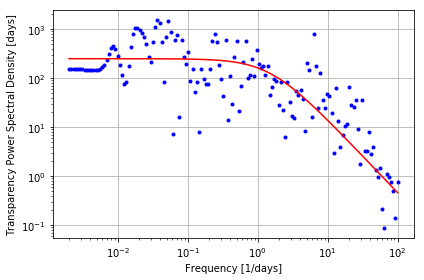

In [22]:
def plot_transp_psd(save=None):
    whiten, unwhiten = desimodel.weather.whiten_transforms(transp, data_min=0, data_max=1.2)
    transp_w = whiten(transp)
    freq = np.logspace(np.log10(0.002), 2, 150)
    pgram = scipy.signal.lombscargle(mjd_transp, transp_w, freq)
    plt.plot(freq, pgram, 'b.')
    plt.plot(freq, desimodel.weather._transp_psd(freq), 'r-')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.xlabel('Frequency [1/days]')
    plt.ylabel('Transparency Power Spectral Density [days]')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_transp_psd() #save='transp-psd.pdf')

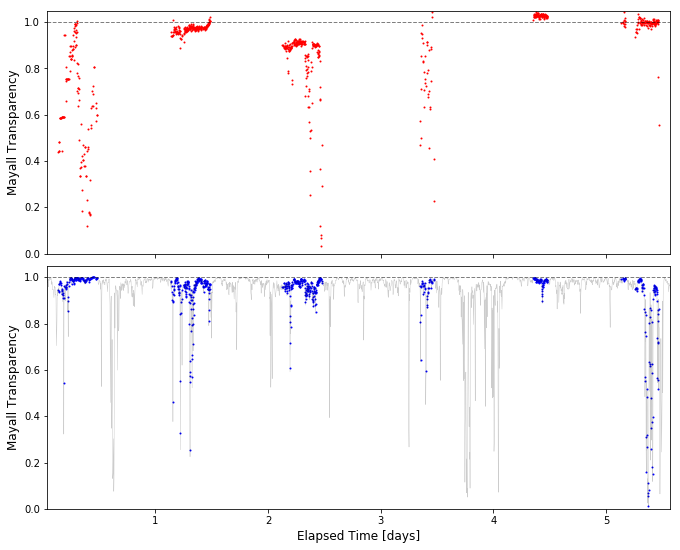

In [23]:
def plot_transp_timeseries(seed=9, truth=False, pad=0.1, rms=0.03, save=None):

    fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 8))
    
    mjd1, mjd2 = 57520, 57526
    sel = (mjd_transp > mjd1) & (mjd_transp < mjd2)
    t_data = (mjd_transp[sel] - mjd1)
    data = transp[sel]
    ax[0].scatter(t_data, data, c='r', s=1)
    ax[0].set_ylabel('Mayall Transparency', fontsize='large')
    ax[0].axhline(1, lw=1, ls='--', c='k', alpha=0.5)
    
    gen = np.random.RandomState(seed)
    dt_sec = 180.
    n_gen = int(np.ceil((t_data[-1] + pad) * 24. * 3600. / dt_sec))
    t_sim = np.arange(n_gen) * dt_sec / (24 * 3600.)
    sim = desimodel.weather.sample_transp(n_gen, dt_sec=dt_sec, gen=gen)
    
    # Interpolate simulated grid to actual observation times.
    sim_data = np.interp(t_data, t_sim, sim)
    
    if truth:
        ax[1].plot(t_sim, sim, 'k-', alpha=0.2, lw=0.5)
    ax[1].scatter(t_data, sim_data, c='b', s=1)
    ax[1].set_xlim(t_data[0] - pad, t_data[-1] + pad)
    ax[1].set_xlabel('Elapsed Time [days]', fontsize='large')
    ax[1].set_ylabel('Mayall Transparency', fontsize='large')
    ax[1].axhline(1, lw=1, ls='--', c='k', alpha=0.5)
    ax[1].set_ylim(0, 1.05)
    
    plt.subplots_adjust(hspace=0.05, right=0.99, top=0.99)
    if save:
        plt.savefig(save)
        
plot_transp_timeseries(truth=True) #, save='transp-sim.png')